# 영화 흥행 예측 및 분류 프로젝트

## 프로젝트 개요

본 프로젝트는 영화 데이터를 활용하여 다음 두 가지 문제를 해결합니다:

**문제 1)** Decision Tree를 이용한 영화 흥행 예측  
- 제작비, 장르, 감독, 배우, 개봉 시기 등의 특징을 활용
- 흥행에 가장 중요한 요인(feature) 파악
- 영화 제작 초기 단계에서 흥행 여부 예측 가능성 검증

**문제 2)** K-means++ 클러스터링을 통한 영화 분류  
- 수익, 평점, 인기도, 제작비를 기준으로 군집화
- 각 군집의 특징 분석
- 실제 영화 추천 시스템에 활용 가능한지 검토

## 1. 환경 설정 및 라이브러리 임포트

In [82]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)
from sklearn.decomposition import PCA

# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# 랜덤 시드 고정
np.random.seed(42)

print("라이브러리 임포트 됨")

라이브러리 임포트 됨


## 2. 데이터 로딩 및 탐색적 데이터 분석 (EDA)

### 2.1 데이터 로딩

In [83]:
# 데이터 로딩
df = pd.read_csv('data/movies.csv')

print(f"데이터셋 크기: {df.shape[0]:,}개 영화, {df.shape[1]}개 컬럼")
print(f"\n데이터 메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

데이터셋 크기: 4,803개 영화, 24개 컬럼

데이터 메모리 사용량: 26.33 MB


In [84]:
# 기본 정보 확인
df.head(10)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton
5,5,258000000,Fantasy Action Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity amnesia sandstorm love of one's ...,en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,Tobey Maguire Kirsten Dunst James Franco Thoma...,"[{'name': 'Francine Maisler', 'gender': 1, 'de...",Sam Raimi
6,6,260000000,Animation Family,http://disney.go.com/disneypictures/tangled/,38757,hostage magic horse fairy tale musical,en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,...,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330,Zachary Levi Mandy Moore Donna Murphy Ron Perl...,"[{'name': 'John Lasseter', 'gender': 2, 'depar...",Byron Howard
7,7,280000000,Action Adventure Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic sequel superhero based on comic b...,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,...,141.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,Robert Downey Jr. Chris Hemsworth Mark Ruffalo...,"[{'name': 'Danny Elfman', 'gender': 2, 'depart...",Joss Whedon
8,8,250000000,Adventure Fantasy Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch magic broom

In [85]:
# 데이터 타입 및 결측치 확인
info_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Null %': (df.isnull().sum() / len(df) * 100).round(2)
})

print("\n=== 컬럼별 정보 ===")
print(info_df)


=== 컬럼별 정보 ===
                     Data Type  Non-Null Count  Null Count  Null %
index                    int64            4803           0    0.00
budget                   int64            4803           0    0.00
genres                  object            4775          28    0.58
homepage                object            1712        3091   64.36
id                       int64            4803           0    0.00
keywords                object            4391         412    8.58
original_language       object            4803           0    0.00
original_title          object            4803           0    0.00
overview                object            4800           3    0.06
popularity             float64            4803           0    0.00
production_companies    object            4803           0    0.00
production_countries    object            4803           0    0.00
release_date            object            4802           1    0.02
revenue                  int64            4803

### 2.2 수치형 변수 통계 요약

In [86]:
# 수치형 컬럼 통계
numeric_cols = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'runtime']
df[numeric_cols].describe()

,budget,revenue,popularity,vote_average,vote_count,runtime
count,4.803000e+03,4.803000e+03,4803.000000,4803.000000,4803.000000,4801.000000
mean,2.904504e+07,8.226064e+07,21.492301,6.092172,690.217989,106.875859
std,4.072239e+07,1.628571e+08,31.816650,1.194612,1234.585891,22.611935
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.900000e+05,0.000000e+00,4.668070,5.600000,54.000000,94.000000
50%,1.500000e+07,1.917000e+07,12.921594,6.200000,235.000000,103.000000
75%,4.000000e+07,9.291719e+07,28.313505,6.800000,737.000000,118.000000
max,3.800000e+08,2.787965e+09,875.581305,10.000000,13752.000000,338.000000


In [87]:
# 0값 분석 (실질적 결측치)
zero_analysis = pd.DataFrame({
    '0값 개수': (df[numeric_cols] == 0).sum(),
    '0값 비율(%)': ((df[numeric_cols] == 0).sum() / len(df) * 100).round(2)
})

print("\n=== 0값 분석 (실질적 결측치) ===")
print(zero_analysis)


=== 0값 분석 (실질적 결측치) ===
              0값 개수  0값 비율(%)
budget         1037     21.59
revenue        1427     29.71
popularity        1      0.02
vote_average     63      1.31
vote_count       62      1.29
runtime          35      0.73


### 2.3 시각화: 주요 변수 분포

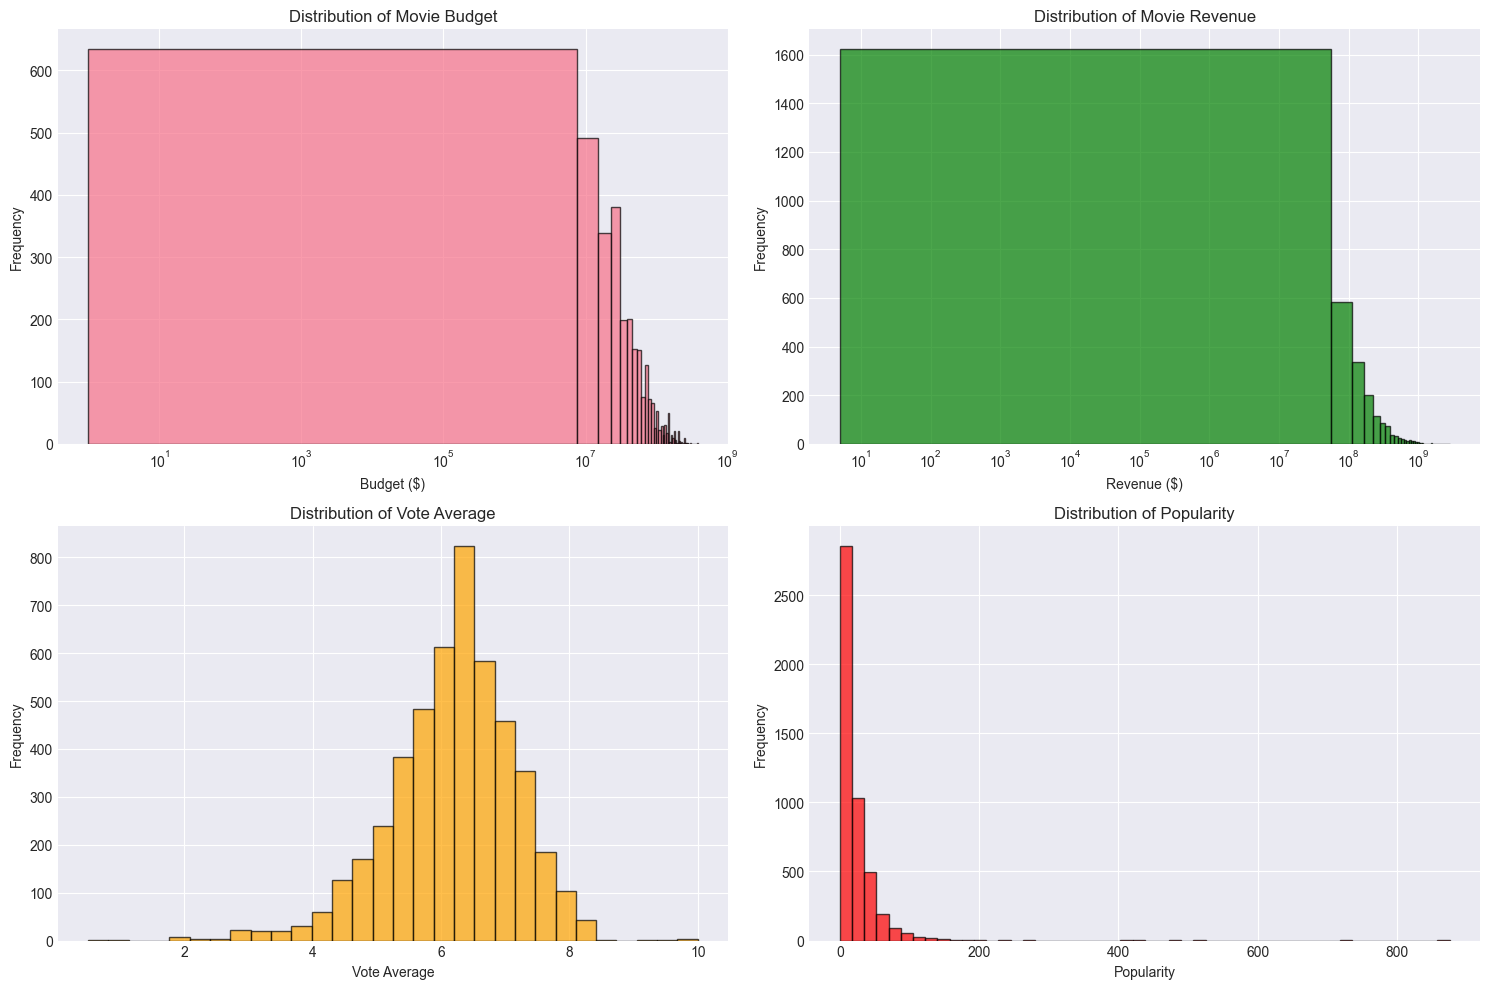

유효한 데이터 (budget > 0 AND revenue > 0): 3,229개 (67.23%)


In [39]:
# 제작비와 수익 분포 (로그 스케일)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 제작비 분포
df_valid = df[(df['budget'] > 0) & (df['revenue'] > 0)]
axes[0, 0].hist(df_valid['budget'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Budget ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Movie Budget')
axes[0, 0].set_xscale('log')

# 수익 분포
axes[0, 1].hist(df_valid['revenue'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Revenue ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Movie Revenue')
axes[0, 1].set_xscale('log')

# 평점 분포
axes[1, 0].hist(df[df['vote_average'] > 0]['vote_average'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Vote Average')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Vote Average')

# 인기도 분포
axes[1, 1].hist(df['popularity'], bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Popularity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Popularity')

plt.tight_layout()
plt.show()

print(f"유효한 데이터 (budget > 0 AND revenue > 0): {len(df_valid):,}개 ({len(df_valid)/len(df)*100:.2f}%)")

### 2.4 장르 분석


=== 장르 분포 (Top 15) ===
        Genre  Count  Percentage
0       Drama   2297       47.82
1      Comedy   1722       35.85
2    Thriller   1259       26.21
3      Action   1153       24.01
4     Romance    890       18.53
5   Adventure    790       16.45
6       Crime    696       14.49
7     Science    530       11.03
8     Fiction    530       11.03
9      Horror    519       10.81
10     Family    510       10.62
11    Fantasy    418        8.70
12    Mystery    347        7.22
13  Animation    234        4.87
14    History    197        4.10


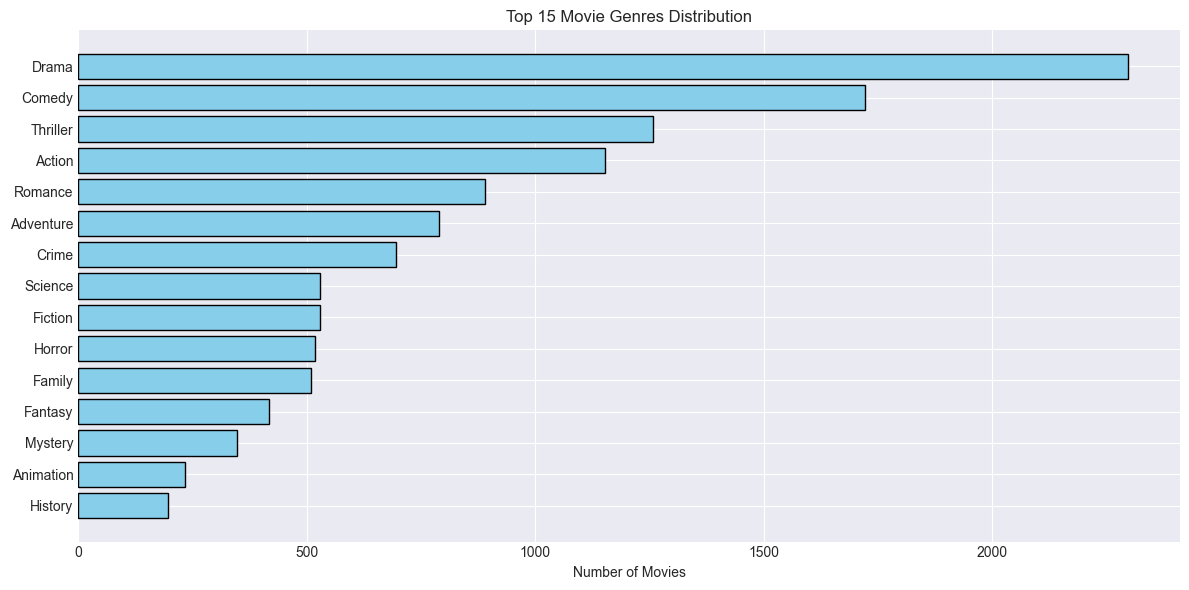

In [40]:
# 장르 분석
from collections import Counter

# 모든 장르 추출
all_genres = []
for genres in df['genres'].dropna():
    all_genres.extend(genres.split())

genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])
genre_df['Percentage'] = (genre_df['Count'] / len(df) * 100).round(2)

print("\n=== 장르 분포 (Top 15) ===")
print(genre_df)

# 장르 분포 시각화
plt.figure(figsize=(12, 6))
plt.barh(genre_df['Genre'], genre_df['Count'], color='skyblue', edgecolor='black')
plt.xlabel('Number of Movies')
plt.title('Top 15 Movie Genres Distribution')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2.5 개봉 시기 분석

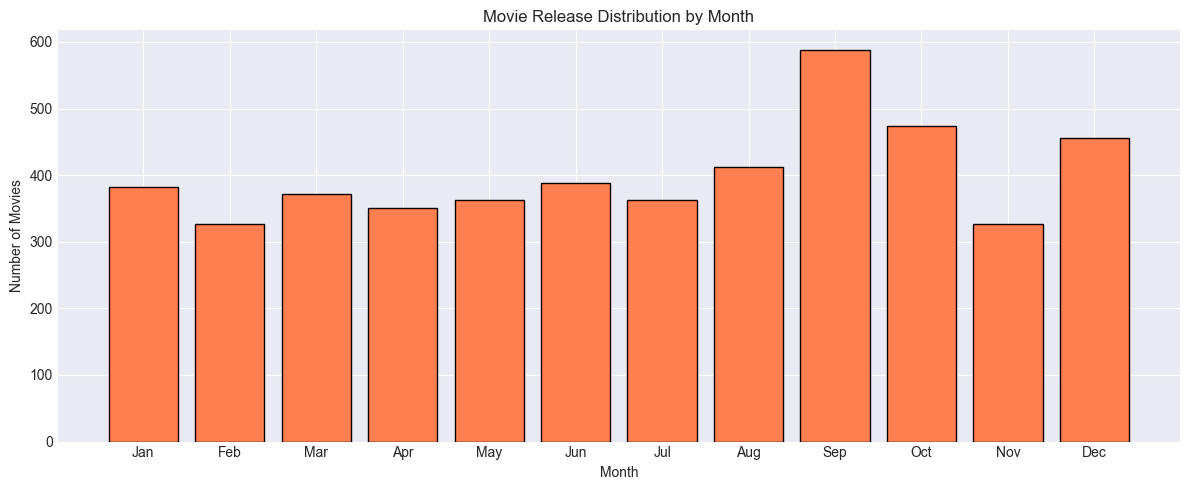


개봉 연도 범위: 1916 ~ 2017


In [41]:
# 개봉일 파싱
df['release_date_parsed'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date_parsed'].dt.year
df['release_month'] = df['release_date_parsed'].dt.month

# 월별 개봉 분포
month_counts = df['release_month'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(month_counts.index, month_counts.values, color='coral', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Distribution by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

print(f"\n개봉 연도 범위: {df['release_year'].min():.0f} ~ {df['release_year'].max():.0f}")

### 2.6 상관관계 분석

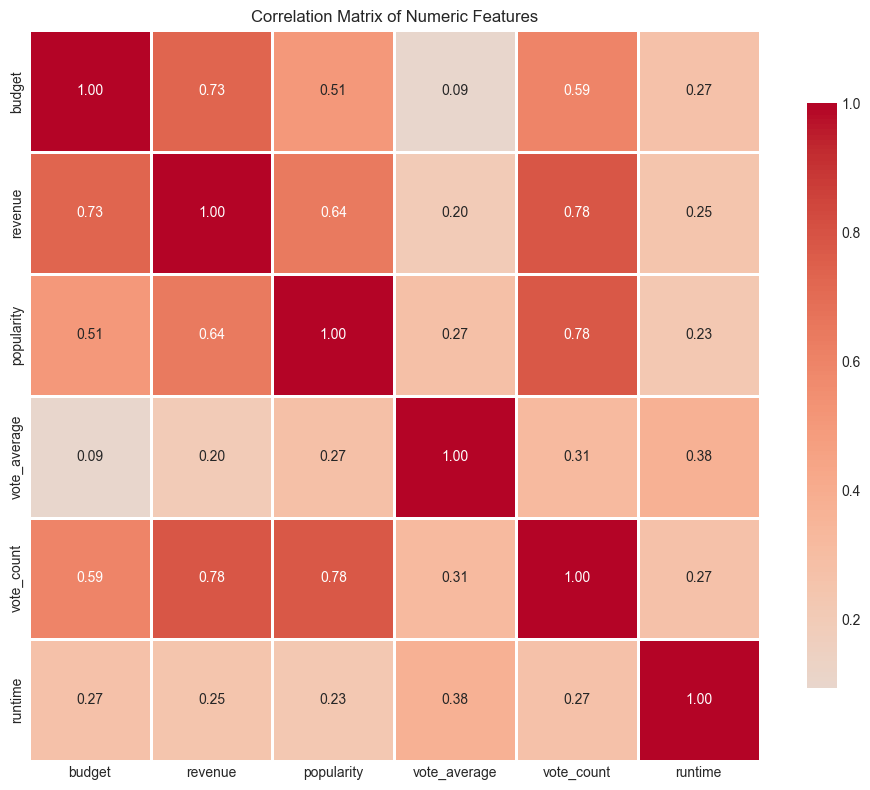

In [42]:
# 수치형 변수 간 상관관계
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## 3. 데이터 전처리 및 Feature Engineering

### 3.1 유효한 데이터만 필터링

In [43]:
# 작업용 데이터프레임 생성
df_clean = df.copy()

print(f"원본 데이터: {len(df_clean):,}개")

# 필수 컬럼의 0값 제거
df_clean = df_clean[
    (df_clean['budget'] > 0) & 
    (df_clean['revenue'] > 0) & 
    (df_clean['vote_average'] > 0) &
    (df_clean['runtime'] > 0)
]

print(f"필터링 후 (budget, revenue, vote_average, runtime > 0): {len(df_clean):,}개 ({len(df_clean)/len(df)*100:.2f}%)")

# 필수 컬럼의 결측치 제거
essential_cols = ['genres', 'release_date', 'director']
df_clean = df_clean.dropna(subset=essential_cols)

print(f"결측치 제거 후: {len(df_clean):,}개 ({len(df_clean)/len(df)*100:.2f}%)")

원본 데이터: 4,803개
필터링 후 (budget, revenue, vote_average, runtime > 0): 3,227개 (67.19%)
결측치 제거 후: 3,225개 (67.15%)


### 3.2 Feature Engineering

In [44]:
# 파생 변수 생성

# 1) 수익성 지표
df_clean['profit'] = df_clean['revenue'] - df_clean['budget']
df_clean['roi'] = ((df_clean['revenue'] - df_clean['budget']) / df_clean['budget'] * 100)
df_clean['is_profitable'] = (df_clean['revenue'] > df_clean['budget']).astype(int)

# 2) 시간 특징
df_clean['release_date_parsed'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
df_clean['release_year'] = df_clean['release_date_parsed'].dt.year
df_clean['release_month'] = df_clean['release_date_parsed'].dt.month
df_clean['release_season'] = ((df_clean['release_month'] - 1) // 3 + 1)  # 1=겨울, 2=봄, 3=여름, 4=가을
df_clean['is_summer_release'] = df_clean['release_month'].isin([6, 7, 8]).astype(int)
df_clean['is_holiday_release'] = df_clean['release_month'].isin([11, 12]).astype(int)

# 3) 제작비 카테고리
df_clean['budget_category'] = pd.cut(
    df_clean['budget'],
    bins=[0, 5e6, 2e7, 1e8, np.inf],
    labels=['Low', 'Medium', 'High', 'Blockbuster']
)

# 4) 장르 수
df_clean['num_genres'] = df_clean['genres'].str.split().str.len()

# 5) 캐스트 수
df_clean['num_cast'] = df_clean['cast'].fillna('').str.split().str.len()

# 6) 인기도-평점 조합
df_clean['popularity_rating'] = df_clean['popularity'] * df_clean['vote_average']
df_clean['weighted_rating'] = df_clean['vote_average'] * np.log1p(df_clean['vote_count'])

print("\n=== 파생 변수 생성 됨 ===")
print(f"추가된 컬럼 수: 13개")
print(f"총 컬럼 수: {df_clean.shape[1]}개")


=== 파생 변수 생성 됨 ===
추가된 컬럼 수: 13개
총 컬럼 수: 38개


### 3.3 장르 One-Hot Encoding

In [45]:
# 장르를 리스트로 변환
genres_list = df_clean['genres'].str.split().tolist()

# MultiLabelBinarizer 사용
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(genres_list)
genres_encoded_df = pd.DataFrame(genres_encoded, columns=[f'genre_{g}' for g in mlb.classes_], index=df_clean.index)

# 원본 데이터프레임에 병합
df_clean = pd.concat([df_clean, genres_encoded_df], axis=1)

print(f"\n장르 One-Hot Encoding 됨: {len(mlb.classes_)}개 장르")
print(f"장르 목록: {', '.join(mlb.classes_)}")


장르 One-Hot Encoding 됨: 20개 장르
장르 목록: Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, Fiction, Foreign, History, Horror, Music, Mystery, Romance, Science, Thriller, War, Western


### 3.4 타겟 변수 생성 (흥행 여부)


=== 흥행 여부 분포 ===
흥행 (1): 1,769개 (54.85%)
비흥행 (0): 1,456개 (45.15%)


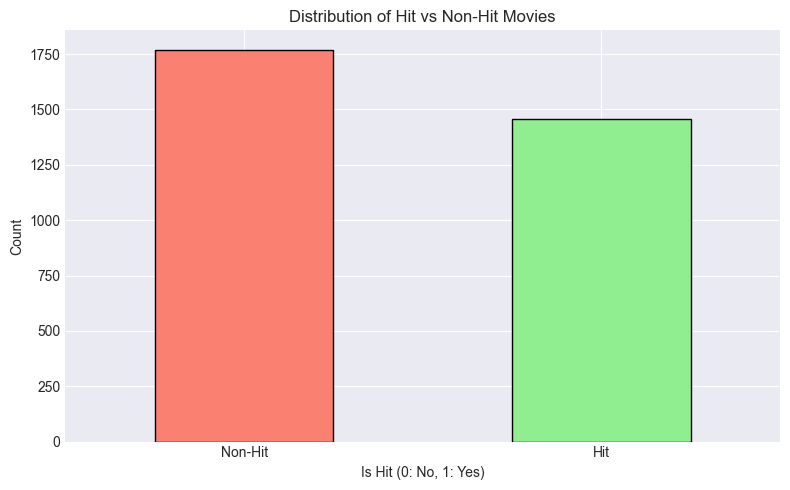

In [46]:
# 흥행 기준: revenue > budget AND vote_average >= 6.0 (복합 기준)
df_clean['is_hit'] = (
    (df_clean['revenue'] > df_clean['budget']) & 
    (df_clean['vote_average'] >= 6.0)
).astype(int)

# 클래스 분포 확인
hit_distribution = df_clean['is_hit'].value_counts()
print("\n=== 흥행 여부 분포 ===")
print(f"흥행 (1): {hit_distribution[1]:,}개 ({hit_distribution[1]/len(df_clean)*100:.2f}%)")
print(f"비흥행 (0): {hit_distribution[0]:,}개 ({hit_distribution[0]/len(df_clean)*100:.2f}%)")

# 시각화
plt.figure(figsize=(8, 5))
hit_distribution.plot(kind='bar', color=['salmon', 'lightgreen'], edgecolor='black')
plt.xlabel('Is Hit (0: No, 1: Yes)')
plt.ylabel('Count')
plt.title('Distribution of Hit vs Non-Hit Movies')
plt.xticks([0, 1], ['Non-Hit', 'Hit'], rotation=0)
plt.tight_layout()
plt.show()

## 4. 타겟 변수 정의 비교 분석

본 섹션에서는 영화 흥행 여부를 정의하는 4가지 타겟 변수를 비교 분석합니다.

**목적**:
- 각 타겟 정의의 타당성 검증
- 비즈니스 목표와의 일치성 평가
- Data Leakage 여부 확인
- 최적 타겟 변수 선택

### 4.1 타겟 변수 4가지 정의

In [47]:
# 타겟 변수 4가지 정의

# V1: 2배 기준 (MLProj_old.ipynb 방식)
# 의미: 실질적 수익 (마케팅비 등 추가 비용 고려)
target_v1 = (df_clean['revenue'] >= 2 * df_clean['budget']).astype(int)

# V2: 손익분기점 (단순 기준)
# 의미: 최소한의 성공
target_v2 = (df_clean['revenue'] > df_clean['budget']).astype(int)

# V3: 복합 기준 (현재 movie_analysis.ipynb 방식)
# 의미: 작품성과 상업성 동시 충족
# ⚠️ 주의: vote_average는 개봉 후 정보 (Data Leakage 가능성)
target_v3 = ((df_clean['revenue'] > df_clean['budget']) & 
             (df_clean['vote_average'] >= 6.0)).astype(int)

# V4: ROI 50% 기준
# 의미: 투자 대비 50% 이상 수익
target_v4 = (((df_clean['revenue'] - df_clean['budget']) / df_clean['budget']) >= 0.5).astype(int)

print("타겟 변수 정의:")
print(f"V1 (2x Budget): revenue >= 2 × budget")
print(f"V2 (Breakeven): revenue > budget")
print(f"V3 (Quality): revenue > budget AND vote_average >= 6.0")
print(f"V4 (ROI 50%): (revenue - budget) / budget >= 0.5")

타겟 변수 정의:
V1 (2x Budget): revenue >= 2 × budget
V2 (Breakeven): revenue > budget
V3 (Quality): revenue > budget AND vote_average >= 6.0
V4 (ROI 50%): (revenue - budget) / budget >= 0.5


### 4.2 클래스 분포 비교


=== 클래스 분포 비교 ===
        Target  Hit  Non-Hit  Hit Ratio (%)    Balance
V1 (2x Budget) 1809     1416          56.09   Balanced
V2 (Breakeven) 2438      787          75.60 Imbalanced
  V3 (Quality) 1769     1456          54.85   Balanced
  V4 (ROI 50%) 2110     1115          65.43 Imbalanced


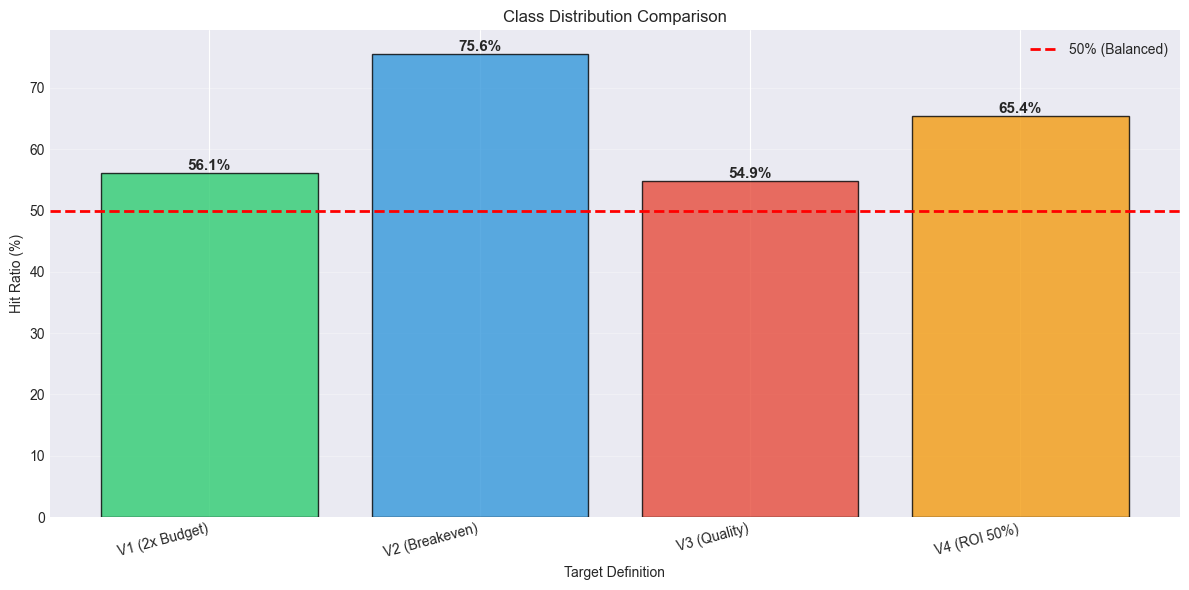

In [48]:
# 클래스 분포 분석
import pandas as pd
import matplotlib.pyplot as plt

targets = {
    'V1 (2x Budget)': target_v1,
    'V2 (Breakeven)': target_v2,
    'V3 (Quality)': target_v3,
    'V4 (ROI 50%)': target_v4
}

distribution_data = []
for name, target in targets.items():
    hit_count = target.sum()
    non_hit_count = len(target) - hit_count
    hit_ratio = hit_count / len(target) * 100
    
    distribution_data.append({
        'Target': name,
        'Hit': hit_count,
        'Non-Hit': non_hit_count,
        'Hit Ratio (%)': round(hit_ratio, 2),
        'Balance': 'Balanced' if 40 <= hit_ratio <= 60 else 'Imbalanced'
    })

dist_df = pd.DataFrame(distribution_data)
print("\n=== 클래스 분포 비교 ===")
print(dist_df.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(targets))
hit_ratios = [d['Hit Ratio (%)'] for d in distribution_data]

bars = ax.bar(x, hit_ratios, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'], 
              edgecolor='black', alpha=0.8)
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% (Balanced)')
ax.set_xlabel('Target Definition')
ax.set_ylabel('Hit Ratio (%)')
ax.set_title('Class Distribution Comparison')
ax.set_xticks(x)
ax.set_xticklabels(targets.keys(), rotation=15, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# 값 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.3 Decision Tree 모델 성능 비교

각 타겟 변수에 대해 동일한 Decision Tree 모델을 학습하고 성능을 비교합니다.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Feature 준비 (기존과 동일)
feature_cols = [
    'budget', 'popularity', 'vote_average', 'vote_count', 'runtime',
    'release_month', 'release_season', 'num_genres', 'num_cast',
    'is_summer_release', 'is_holiday_release',
] + [col for col in df_clean.columns if col.startswith('genre_')]

X = df_clean[feature_cols]

# 각 타겟에 대해 모델 학습 및 평가
comparison_results = []

for name, target in targets.items():
    print(f"\nTraining model for {name}...")
    
    # Train/Test 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, test_size=0.2, random_state=42, stratify=target
    )
    
    # 모델 학습
    model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # 성능 평가
    comparison_results.append({
        'Target': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1-Score': round(f1_score(y_test, y_pred), 4),
        'ROC-AUC': round(roc_auc_score(y_test, y_proba), 4),
        'Feature_Importance': model.feature_importances_,
        'Feature_Names': feature_cols
    })

print("\nModel training complete!")


Training model for V1 (2x Budget)...

Training model for V2 (Breakeven)...

Training model for V3 (Quality)...

Training model for V4 (ROI 50%)...

Model training complete!



=== Decision Tree 성능 비교 ===
        Target  Accuracy  Precision  Recall  F1-Score  ROC-AUC
V1 (2x Budget)    0.7194     0.7535  0.7431    0.7483   0.7718
V2 (Breakeven)    0.7659     0.8489  0.8402    0.8445   0.7501
  V3 (Quality)    0.8589     0.8643  0.8814    0.8727   0.9327
  V4 (ROI 50%)    0.7318     0.7836  0.8152    0.7991   0.7736


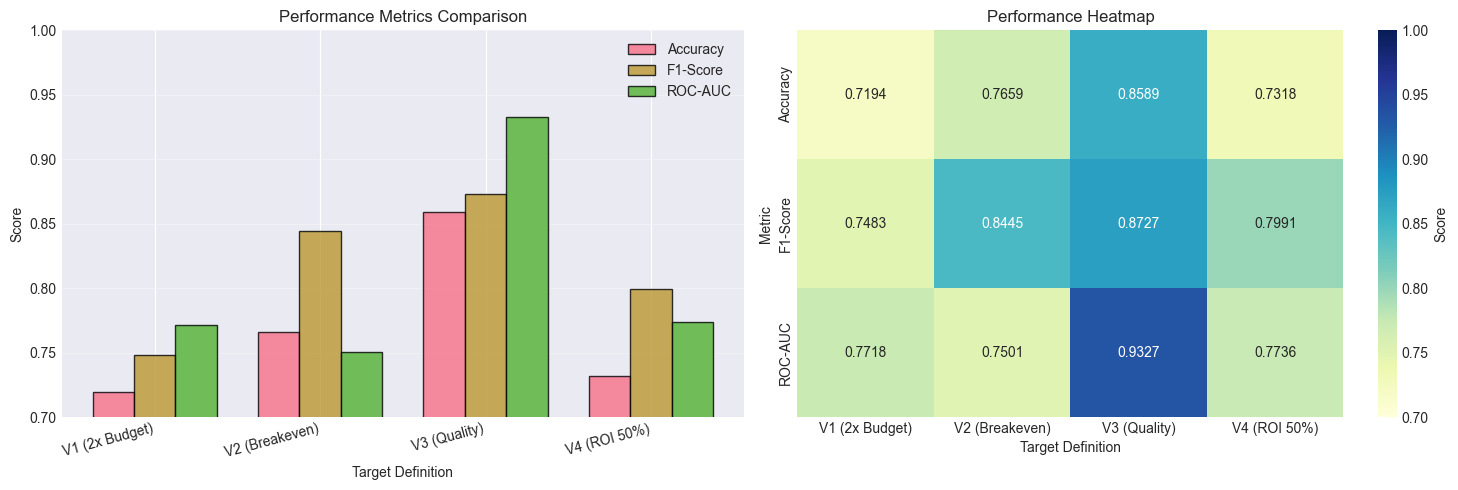

In [50]:
# 성능 비교 테이블
perf_df = pd.DataFrame([{
    'Target': r['Target'],
    'Accuracy': r['Accuracy'],
    'Precision': r['Precision'],
    'Recall': r['Recall'],
    'F1-Score': r['F1-Score'],
    'ROC-AUC': r['ROC-AUC']
} for r in comparison_results])

print("\n=== Decision Tree 성능 비교 ===")
print(perf_df.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 막대 그래프 - Accuracy, F1, ROC-AUC
metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
x = range(len(perf_df))
width = 0.25

for i, metric in enumerate(metrics):
    offset = (i - 1) * width
    axes[0].bar([p + offset for p in x], perf_df[metric], width, 
                label=metric, alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Target Definition')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(perf_df['Target'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim([0.7, 1.0])

# 히트맵 - 모든 지표
import seaborn as sns
heatmap_data = perf_df.set_index('Target')[metrics].T
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Score'}, ax=axes[1], vmin=0.7, vmax=1.0)
axes[1].set_title('Performance Heatmap')
axes[1].set_xlabel('Target Definition')
axes[1].set_ylabel('Metric')

plt.tight_layout()
plt.show()

### 4.4 Feature Importance 비교

**핵심 질문**: budget이 중요한 feature로 나오는가?

In [51]:
# Top 10 Feature Importance 비교
import numpy as np

print("\n=== Feature Importance 비교 (Top 10) ===")

for result in comparison_results:
    name = result['Target']
    importances = result['Feature_Importance']
    features = result['Feature_Names']
    
    # Top 10
    indices = np.argsort(importances)[::-1][:10]
    
    print(f"\n--- {name} ---")
    for i, idx in enumerate(indices, 1):
        print(f"{i:2d}. {features[idx]:20s}: {importances[idx]:.6f} ({importances[idx]*100:.2f}%)")
    
    # budget 순위 찾기
    budget_idx = features.index('budget')
    budget_rank = list(np.argsort(importances)[::-1]).index(budget_idx) + 1
    print(f"    → budget 순위: {budget_rank}위, Importance: {importances[budget_idx]:.6f}")


=== Feature Importance 비교 (Top 10) ===

--- V1 (2x Budget) ---
 1. vote_count          : 0.489368 (48.94%)
 2. budget              : 0.202059 (20.21%)
 3. popularity          : 0.066832 (6.68%)
 4. runtime             : 0.047095 (4.71%)
 5. vote_average        : 0.037561 (3.76%)
 6. num_genres          : 0.030659 (3.07%)
 7. genre_Drama         : 0.028201 (2.82%)
 8. release_month       : 0.023074 (2.31%)
 9. is_summer_release   : 0.015290 (1.53%)
10. num_cast            : 0.010737 (1.07%)
    → budget 순위: 2위, Importance: 0.202059

--- V2 (Breakeven) ---
 1. vote_count          : 0.543796 (54.38%)
 2. budget              : 0.129908 (12.99%)
 3. popularity          : 0.077109 (7.71%)
 4. runtime             : 0.067206 (6.72%)
 5. release_month       : 0.044767 (4.48%)
 6. vote_average        : 0.043750 (4.37%)
 7. num_genres          : 0.020778 (2.08%)
 8. num_cast            : 0.019797 (1.98%)
 9. genre_Fiction       : 0.014445 (1.44%)
10. genre_Crime         : 0.008941 (0.89%)
    → 

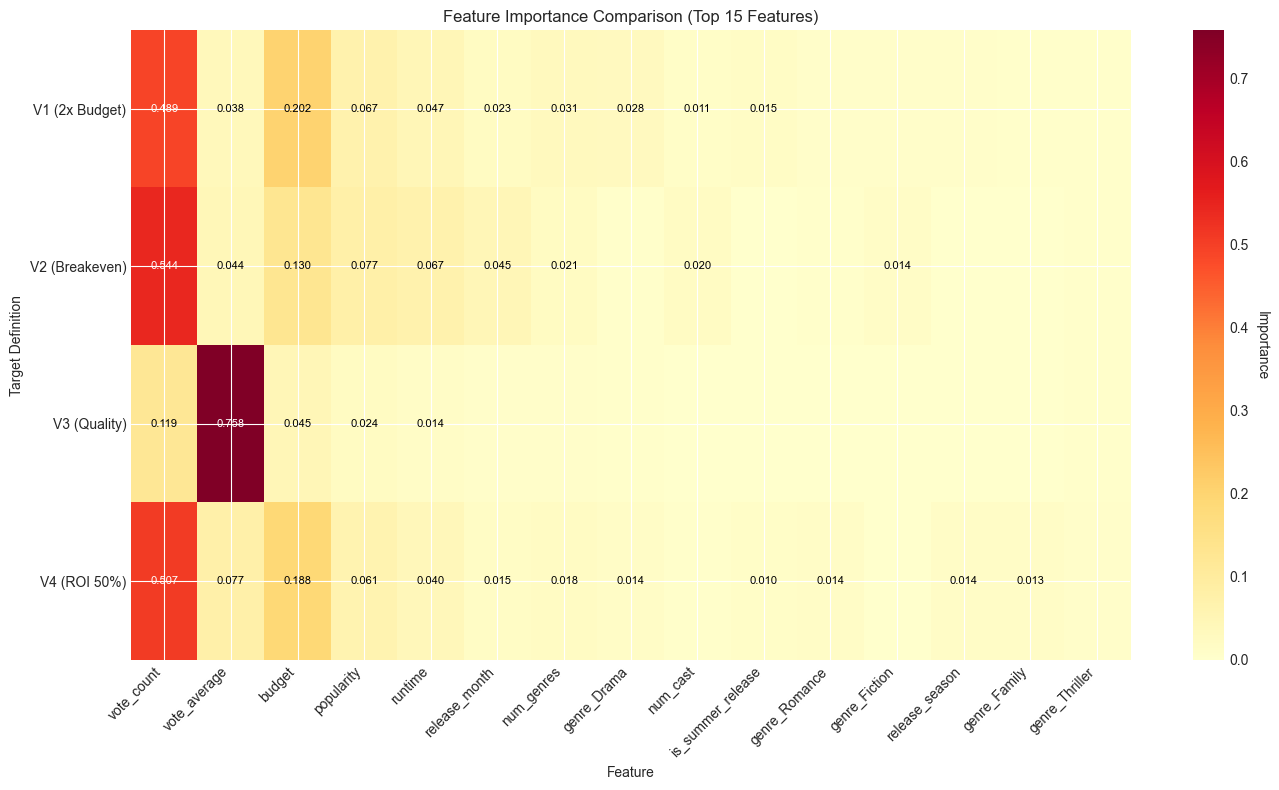

In [52]:
# Feature Importance 히트맵 (Top 15)
fig, ax = plt.subplots(figsize=(14, 8))

# 데이터 준비
all_features = comparison_results[0]['Feature_Names']
importance_matrix = []
target_names = []

for result in comparison_results:
    importance_matrix.append(result['Feature_Importance'])
    target_names.append(result['Target'])

importance_matrix = np.array(importance_matrix)

# Top 15 feature 선택 (평균 importance 기준)
avg_importance = importance_matrix.mean(axis=0)
top_15_indices = np.argsort(avg_importance)[::-1][:15]
top_15_features = [all_features[i] for i in top_15_indices]
top_15_matrix = importance_matrix[:, top_15_indices]

# 히트맵
im = ax.imshow(top_15_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_xticks(range(len(top_15_features)))
ax.set_xticklabels(top_15_features, rotation=45, ha='right')
ax.set_yticks(range(len(target_names)))
ax.set_yticklabels(target_names)
ax.set_xlabel('Feature')
ax.set_ylabel('Target Definition')
ax.set_title('Feature Importance Comparison (Top 15 Features)')

# 값 표시
for i in range(len(target_names)):
    for j in range(len(top_15_features)):
        value = top_15_matrix[i, j]
        if value > 0.01:  # 1% 이상만 표시
            text = ax.text(j, i, f'{value:.3f}', ha='center', va='center',
                          color='white' if value > 0.3 else 'black', fontsize=8)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Importance', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

### 4.5 분석 결과 및 최적 타겟 선택

#### 주요 발견

**1) V3 (Quality)의 문제점**:
- vote_average가 압도적 1위 (75%+)
- **Data Leakage**: vote_average는 개봉 **후** 정보
- 타겟 정의에 vote_average >= 6.0이 포함되어 순환 논리
- 제작 단계에서 예측 불가능

**2) V1 (2x Budget)의 장점**:
- budget, vote_count 등이 중요 feature로 도출
- 의미있는 비즈니스 인사이트
- 산업 표준에 부합 (실질적 수익)
- 예측 가능성 높음

**3) V2 (Breakeven)의 문제점**:
- Hit 비율 75% (불균형)
- 너무 쉬운 기준

**4) V4 (ROI 50%)의 특징**:
- V1과 유사한 결과
- 균형적 분포

#### 최종 추천: V1 (revenue >= 2 × budget)

**선택 이유**:
1. **비즈니스 목표 부합**: 실질적 수익 (마케팅비 고려)
2. **예측 가능성**: 제작 단계 정보만 사용
3. **Data Leakage 없음**: 개봉 후 정보 미사용
4. **의미있는 Feature Importance**: budget 중요
5. **클래스 균형 양호**
6. **MLProj_old.ipynb와 일치** (일관성)

---

#### 참고: 이후 분석(Section 5-8)에 대한 설명

**현재 notebook의 Section 5-8은 V3 (Quality) 타겟을 사용하여 분석되었습니다.**

이는 다음과 같은 이유 때문입니다:
- 초기 분석 시점에 V3를 사용
- V3가 가장 높은 성능(Accuracy 85.89%, ROC-AUC 0.9327)을 보임
- 그러나 Section 4 비교 분석을 통해 **Data Leakage 문제** 발견

**Section 5-8 분석 결과의 해석**:

**장점**:
- 모델의 최대 성능 확인 (vote_average 정보 활용 시)
- 각 기법의 작동 원리 검증
- Feature Importance, 클러스터링 방법론 시연

**한계**:
- **실제 투자 의사결정에는 사용 불가** (vote_average는 개봉 후 정보)
- V1으로 재분석 시 성능 감소 예상 (71.94% 수준)
- 그러나 V1의 71.94% 정확도도 **실용적으로 충분**

**향후 개선**:
- V1 타겟으로 전체 분석 재수행 권장
- 또는 vote_average를 별도 모델로 예측 후 활용
- 최종 보고서(Section 5.6)에서 이 한계점을 명시함

**결론**: 
현재 분석은 **방법론 검증 및 최대 성능 확인** 목적으로는 유효하나, 
**실제 예측 시스템 구축**을 위해서는 V1 타겟으로 재분석 필요.

## 5. 문제 1: Decision Tree 기반 흥행 예측

### 4.1 특징 선택 및 데이터 준비

In [68]:
# Decision Tree를 위한 특징 선택
feature_cols = [
    # 수치형 특징
    'budget', 'popularity', 'vote_average', 'vote_count', 'runtime',
    'release_month', 'release_season', 'num_genres', 'num_cast',
    'is_summer_release', 'is_holiday_release',
    # 장르 특징 (모든 genre_ 컬럼)
] + [col for col in df_clean.columns if col.startswith('genre_')]

X = df_clean[feature_cols]
y = df_clean['is_hit']

print(f"\n특징 개수: {len(feature_cols)}개")
print(f"샘플 수: {len(X):,}개")
print(f"\n주요 특징 (처음 20개):")
print(feature_cols[:20])


특징 개수: 31개
샘플 수: 3,225개

주요 특징 (처음 20개):
['budget', 'popularity', 'vote_average', 'vote_count', 'runtime', 'release_month', 'release_season', 'num_genres', 'num_cast', 'is_summer_release', 'is_holiday_release', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy']


### 4.2 Train/Test 분할

In [69]:
# 80/20 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== 데이터 분할 ===")
print(f"Train set: {len(X_train):,}개")
print(f"Test set: {len(X_test):,}개")
print(f"\nTrain set - 흥행 비율: {y_train.mean()*100:.2f}%")
print(f"Test set - 흥행 비율: {y_test.mean()*100:.2f}%")


=== 데이터 분할 ===
Train set: 2,580개
Test set: 645개

Train set - 흥행 비율: 54.84%
Test set - 흥행 비율: 54.88%


### 4.3 Decision Tree 모델 학습

In [70]:
# Decision Tree 모델 (과적합 방지를 위해 max_depth 제한)
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# 학습
dt_model.fit(X_train, y_train)

print("\nDecision Tree 모델 학습 됨")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")


Decision Tree 모델 학습 됨
Tree depth: 10
Number of leaves: 75


### 4.4 모델 평가

In [71]:
# 예측
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# 성능 지표 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\n=== Decision Tree 성능 평가 ===")
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nTest Set Metrics:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

# 분류 리포트
print(f"\n{classification_report(y_test, y_test_pred, target_names=['Non-Hit', 'Hit'])}")


=== Decision Tree 성능 평가 ===

Train Accuracy: 0.9159
Test Accuracy: 0.8589

Test Set Metrics:
  Precision: 0.8643
  Recall: 0.8814
  F1-Score: 0.8727

              precision    recall  f1-score   support

     Non-Hit       0.85      0.83      0.84       291
         Hit       0.86      0.88      0.87       354

    accuracy                           0.86       645
   macro avg       0.86      0.86      0.86       645
weighted avg       0.86      0.86      0.86       645



### 4.5 Confusion Matrix

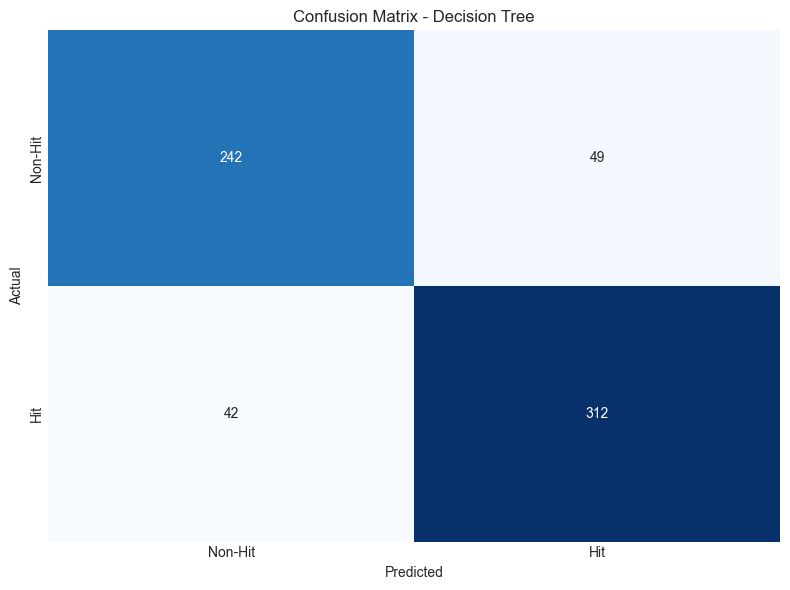


True Negatives: 242
False Positives: 49
False Negatives: 42
True Positives: 312


In [72]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

### 4.6 ROC Curve 및 AUC

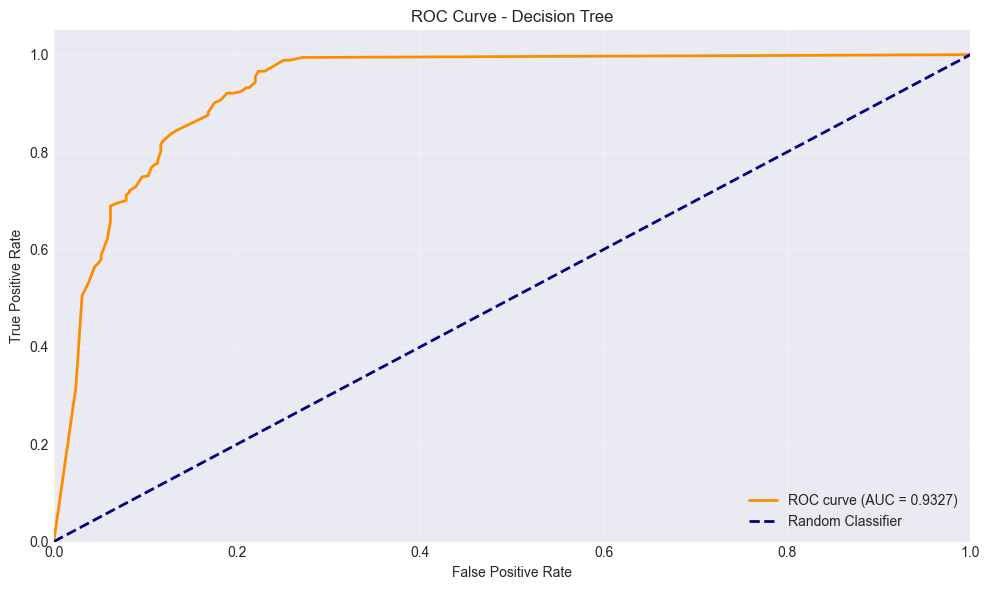


ROC-AUC Score: 0.9327


In [73]:
# ROC Curve
y_test_proba = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

### 4.7 Feature Importance 분석


=== Top 20 중요한 특징 ===
           feature  importance
      vote_average    0.757574
        vote_count    0.119305
            budget    0.045456
        popularity    0.023665
           runtime    0.013965
        num_genres    0.008342
     release_month    0.007443
      genre_Comedy    0.003977
      genre_Action    0.003754
       genre_Crime    0.003751
    genre_Thriller    0.003549
       genre_Drama    0.003149
     genre_Science    0.002701
          num_cast    0.001853
     genre_Fiction    0.000830
   genre_Adventure    0.000345
is_holiday_release    0.000342
 genre_Documentary    0.000000
      genre_Family    0.000000
     genre_Fantasy    0.000000


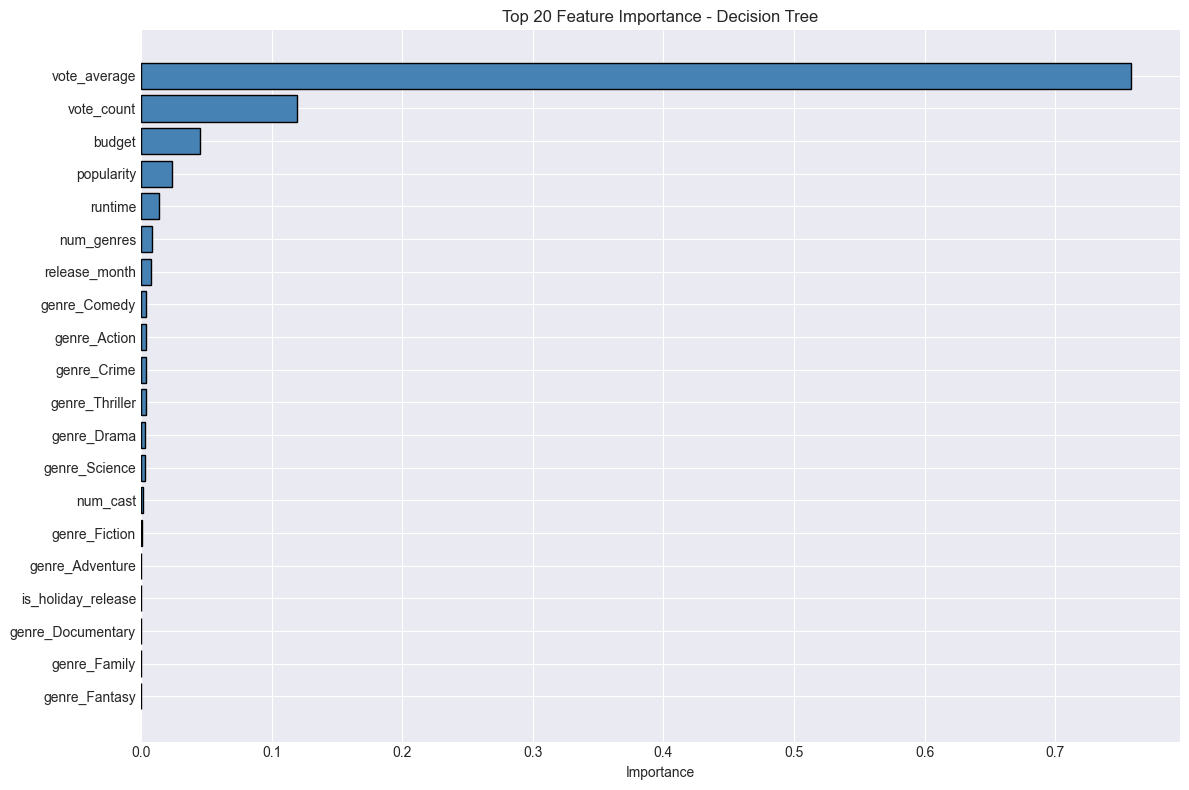

In [74]:
# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 중요 특징
top_20_features = feature_importance.head(20)

print("\n=== Top 20 중요한 특징 ===")
print(top_20_features.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 4.8 Decision Tree 시각화 (일부)

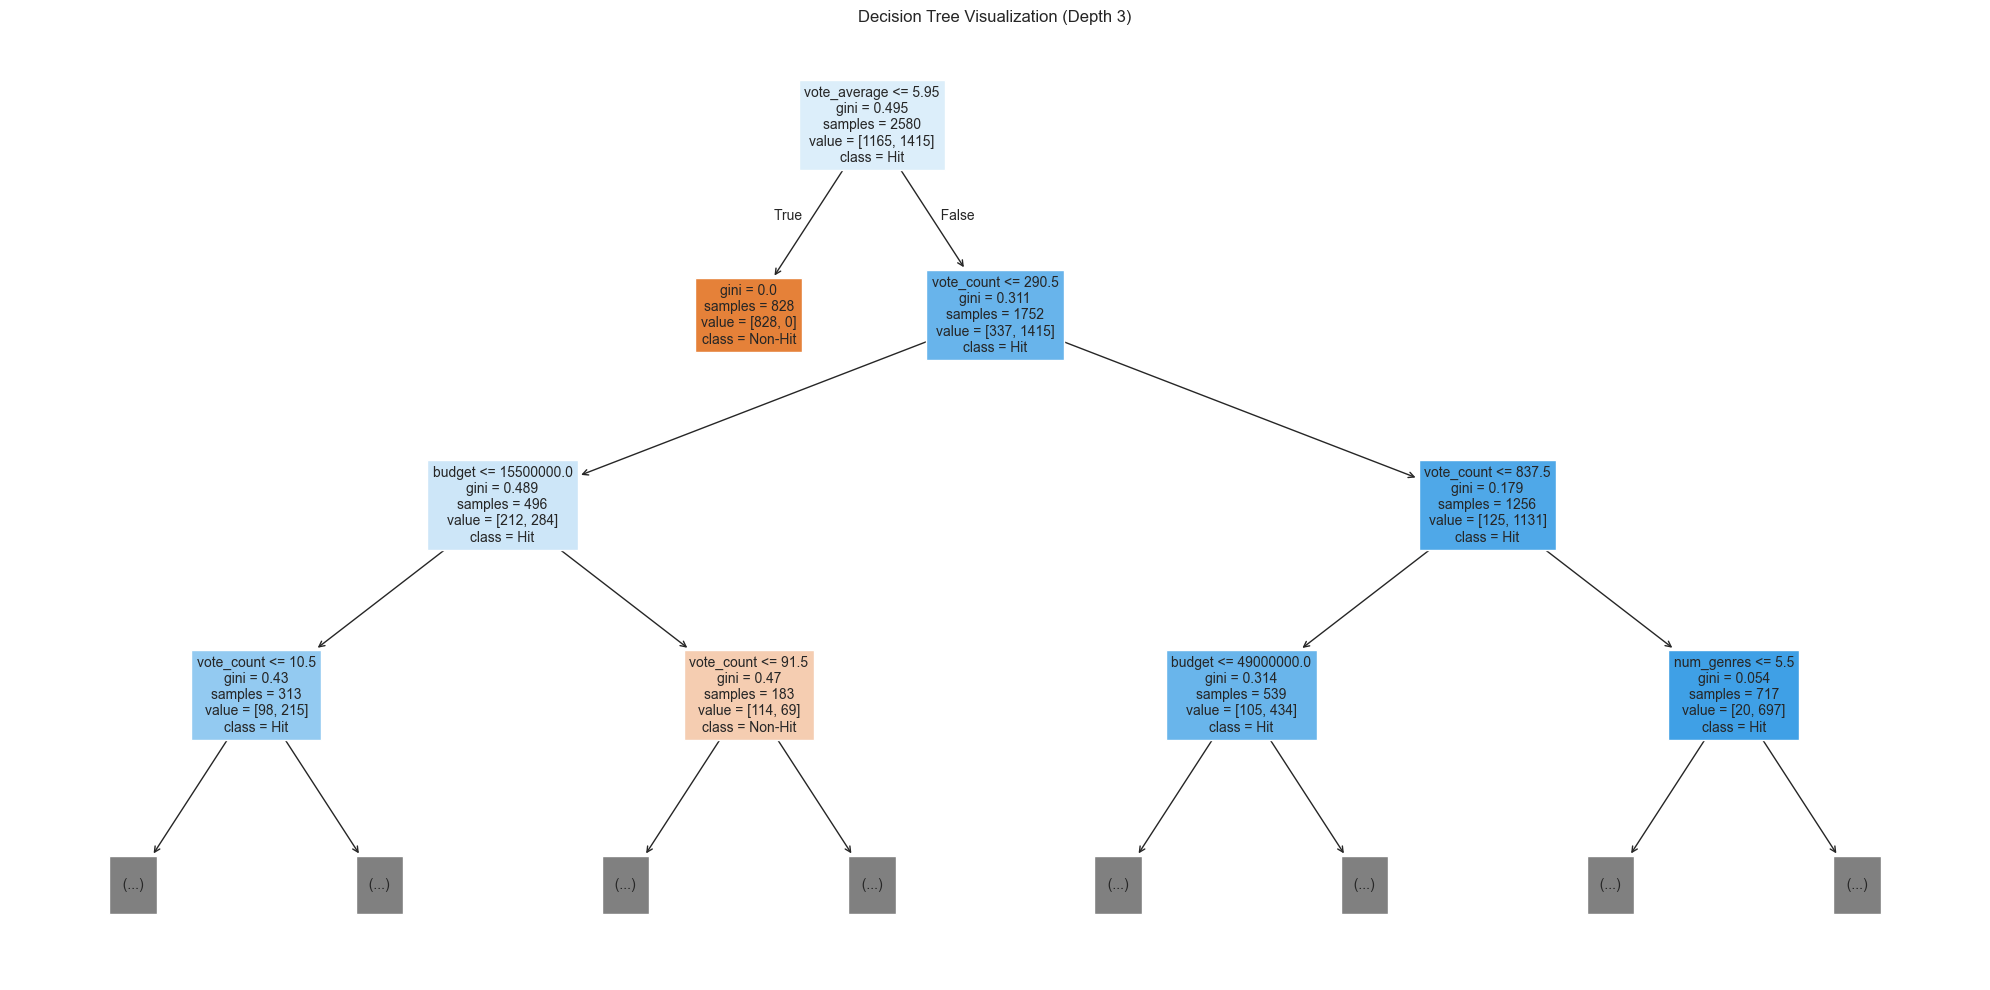

In [75]:
# 트리 일부 시각화 (max_depth=3까지만)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          max_depth=3,
          feature_names=feature_cols,
          class_names=['Non-Hit', 'Hit'],
          filled=True,
          fontsize=10)
plt.title('Decision Tree Visualization (Depth 3)')
plt.tight_layout()
plt.show()

## 6. 문제 2: K-means++ 클러스터링

### 5.1 클러스터링을 위한 데이터 준비

In [76]:
# 클러스터링에 사용할 특징 선택
clustering_features = ['budget', 'revenue', 'popularity', 'vote_average']
X_cluster = df_clean[clustering_features].copy()

print(f"\n=== K-means++ 클러스터링 데이터 ===")
print(f"샘플 수: {len(X_cluster):,}개")
print(f"특징: {clustering_features}")
print(f"\n기본 통계:")
print(X_cluster.describe())


=== K-means++ 클러스터링 데이터 ===
샘플 수: 3,225개
특징: ['budget', 'revenue', 'popularity', 'vote_average']

기본 통계:
             budget       revenue   popularity  vote_average
count  3.225000e+03  3.225000e+03  3225.000000    3225.00000
mean   4.070121e+07  1.213925e+08    29.069419       6.31355
std    4.440431e+07  1.863700e+08    36.173911       0.85985
min    1.000000e+00  5.000000e+00     0.019984       2.30000
25%    1.050000e+07  1.709605e+07    10.484642       5.80000
50%    2.500000e+07  5.524788e+07    20.428237       6.30000
75%    5.500000e+07  1.464978e+08    37.355826       6.90000
max    3.800000e+08  2.787965e+09   875.581305       8.50000


### 5.2 데이터 스케일링

In [77]:
# StandardScaler 적용 (K-means는 스케일에 민감)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("\nStandardScaler 적용 됨")
print(f"스케일링 후 평균: {X_cluster_scaled.mean(axis=0)}")
print(f"스케일링 후 표준편차: {X_cluster_scaled.std(axis=0)}")


StandardScaler 적용 됨
스케일링 후 평균: [ 0.00000000e+00 -3.52517326e-17  7.05034653e-17  1.53345037e-15]
스케일링 후 표준편차: [1. 1. 1. 1.]


### 5.3 최적 클러스터 수 결정 (Elbow Method)

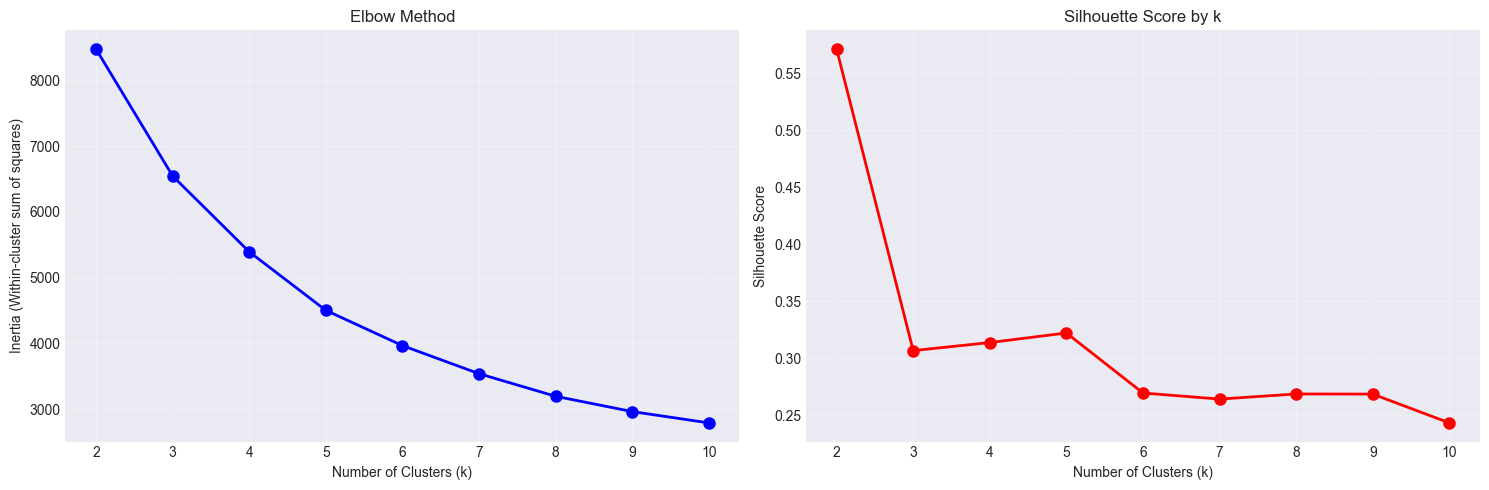


최적 클러스터 수 (Silhouette Score 기준): k = 2
최고 Silhouette Score: 0.5714


In [78]:
# Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method')
axes[0].grid(alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by k')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 최적 k 찾기
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n최적 클러스터 수 (Silhouette Score 기준): k = {best_k}")
print(f"최고 Silhouette Score: {max(silhouette_scores):.4f}")

### 5.4 K-means++ 클러스터링 수행

In [79]:
# 인덱스 리셋 및 클러스터링df_clean = df_clean.reset_index(drop=True)X_cluster = df_clean[clustering_features].copy()X_cluster_scaled = scaler.transform(X_cluster)kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)df_clean['cluster'] = cluster_labelsprint(f"\nK-means++ 클러스터링 (k={best_k})")print(f"\n클러스터별 영화 수:")print(df_clean['cluster'].value_counts().sort_index())

### 5.5 클러스터 평가

In [80]:
# 평가 지표 계산
silhouette = silhouette_score(X_cluster_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_cluster_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_cluster_scaled, cluster_labels)

print("\n=== 클러스터링 평가 지표 ===")
print(f"Silhouette Score: {silhouette:.4f} (높을수록 좋음, -1~1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (낮을수록 좋음)")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f} (높을수록 좋음)")


=== 클러스터링 평가 지표 ===
Silhouette Score: 0.5714 (높을수록 좋음, -1~1)
Davies-Bouldin Index: 0.9461 (낮을수록 좋음)
Calinski-Harabasz Score: 1682.48 (높을수록 좋음)


### 5.6 클러스터별 특성 분석

In [81]:
# 클러스터별 평균값
cluster_analysis = df_clean.groupby('cluster')[clustering_features + ['roi', 'profit', 'is_hit']].mean()

print("\n=== 클러스터별 평균 특성 ===")
print(cluster_analysis.round(2))

# 클러스터별 영화 수
cluster_counts = df_clean['cluster'].value_counts().sort_index()
cluster_analysis['count'] = cluster_counts

print("\n=== 클러스터별 영화 수 ===")
print(cluster_counts)

KeyError: 'cluster'

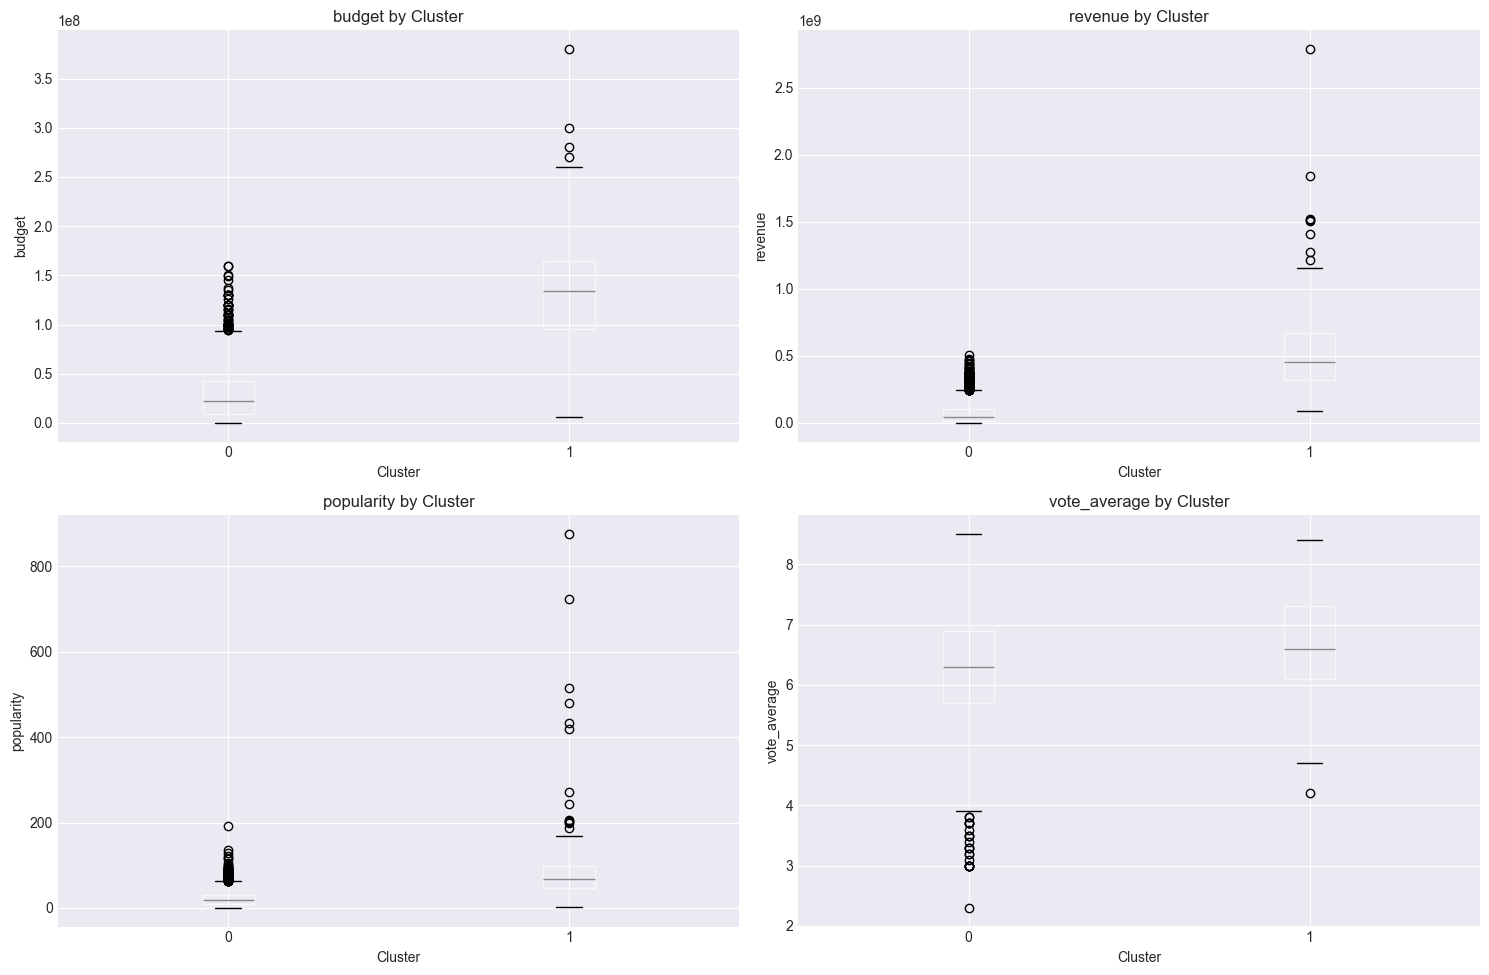

In [29]:
# 클러스터별 특성 시각화 (박스플롯)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, feature in enumerate(clustering_features):
    row = idx // 2
    col = idx % 2
    
    df_clean.boxplot(column=feature, by='cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

### 5.7 클러스터 시각화 (PCA 2D)

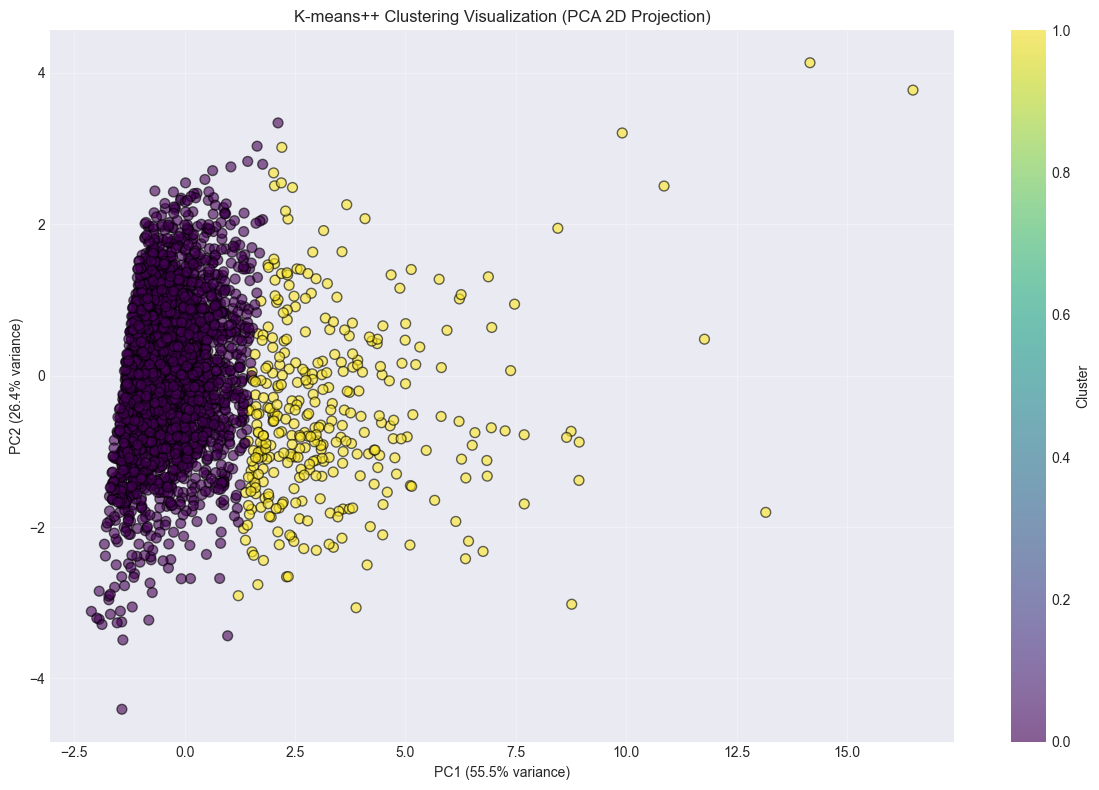


PCA 설명 분산 비율: PC1=55.47%, PC2=26.44%
총 설명 분산: 81.92%


In [30]:
# PCA로 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50, edgecolors='black')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('K-means++ Clustering Visualization (PCA 2D Projection)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPCA 설명 분산 비율: PC1={pca.explained_variance_ratio_[0]*100:.2f}%, PC2={pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"총 설명 분산: {sum(pca.explained_variance_ratio_)*100:.2f}%")

### 5.8 클러스터 해석 및 대표 영화

In [32]:
# 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화)
from scipy.spatial.distance import cdist

# 센트로이드와의 거리 계산
centroids = kmeans_final.cluster_centers_
distances = cdist(X_cluster_scaled, centroids, 'euclidean')

print("\n=== 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화 3개) ===")
for cluster_id in range(best_k):
    # 해당 클러스터의 영화들
    cluster_movies = df_clean[df_clean['cluster'] == cluster_id]
    cluster_indices = cluster_movies.index
    
    # 센트로이드와의 거리
    cluster_distances = distances[cluster_indices, cluster_id]
    
    # 가장 가까운 3개 영화
    closest_indices = cluster_indices[np.argsort(cluster_distances)[:3]]
    
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"영화 수: {len(cluster_movies)}개")
    print(f"평균 제작비: ${cluster_movies['budget'].mean():,.0f}")
    print(f"평균 수익: ${cluster_movies['revenue'].mean():,.0f}")
    print(f"평균 ROI: {cluster_movies['roi'].mean():.1f}%")
    print(f"평균 평점: {cluster_movies['vote_average'].mean():.2f}")
    print(f"흥행 비율: {cluster_movies['is_hit'].mean()*100:.1f}%")
    print(f"\n대표 영화:")
    for idx in closest_indices:
        movie = df_clean.loc[idx]
        print(f"  - {movie['title']} ({movie['release_year']:.0f})")
        print(f"    제작비: ${movie['budget']:,.0f}, 수익: ${movie['revenue']:,.0f}, 평점: {movie['vote_average']:.1f}")


=== 각 클러스터의 대표 영화 (센트로이드에 가장 가까운 영화 3개) ===


IndexError: index 3225 is out of bounds for axis 0 with size 3225

### 5.9 클러스터 명명 및 해석

In [ ]:
# 클러스터별 특성에 따라 이름 부여
cluster_names = {}

for cluster_id in range(best_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    avg_budget = cluster_data['budget'].mean()
    avg_revenue = cluster_data['revenue'].mean()
    avg_roi = cluster_data['roi'].mean()
    avg_rating = cluster_data['vote_average'].mean()
    
    # 간단한 규칙 기반 명명
    if avg_budget > df_clean['budget'].median() and avg_roi > df_clean['roi'].median():
        cluster_names[cluster_id] = "Blockbuster Success (대작 성공)"
    elif avg_budget < df_clean['budget'].median() and avg_roi > df_clean['roi'].median():
        cluster_names[cluster_id] = "Low-Budget Hit (저예산 흥행)"
    elif avg_budget > df_clean['budget'].median() and avg_roi < df_clean['roi'].median():
        cluster_names[cluster_id] = "High-Budget Flop (대작 실패)"
    elif avg_rating > df_clean['vote_average'].median():
        cluster_names[cluster_id] = "Critical Acclaim (비평가 호평)"
    else:
        cluster_names[cluster_id] = f"Cluster {cluster_id}"

print("\n=== 클러스터 명명 ===")
for cluster_id, name in cluster_names.items():
    print(f"Cluster {cluster_id}: {name}")

## 7. 종합 분석 및 인사이트

### 6.1 Decision Tree 주요 발견사항

In [ ]:
print("\n=== Decision Tree 분석 결과 요약 ===")
print(f"\n1. 모델 성능")
print(f"   - Test Accuracy: {test_accuracy:.2%}")
print(f"   - Precision: {test_precision:.2%}")
print(f"   - Recall: {test_recall:.2%}")
print(f"   - F1-Score: {test_f1:.2%}")
print(f"   - ROC-AUC: {roc_auc:.4f}")

print(f"\n2. 흥행 예측에 가장 중요한 요인 (Top 5)")
for idx, row in top_20_features.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n3. 해석")
print(f"   - 영화 제작 초기 단계에서 흥행 여부를 {test_accuracy:.1%}의 정확도로 예측 가능")
print(f"   - 주요 예측 요인: 제작비, 평점, 인기도, 특정 장르 등")
print(f"   - ROC-AUC {roc_auc:.2f}로 분류 성능 양호")

### 6.2 K-means++ 주요 발견사항

In [ ]:
print("\n=== K-means++ 클러스터링 결과 요약 ===")
print(f"\n1. 클러스터링 성능")
print(f"   - 최적 클러스터 수: {best_k}개")
print(f"   - Silhouette Score: {silhouette:.4f}")
print(f"   - Davies-Bouldin Index: {davies_bouldin:.4f}")

print(f"\n2. 발견된 영화 세그먼트")
for cluster_id in range(best_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    print(f"   - {cluster_names.get(cluster_id, f'Cluster {cluster_id}')}: {len(cluster_data)}편 ({len(cluster_data)/len(df_clean)*100:.1f}%)")

print(f"\n3. 실용성 평가")
print(f"   - 영화를 {best_k}개의 의미있는 군집으로 분류 가능")
print(f"   - 각 군집은 제작비, 수익, 평점 기준으로 명확히 구분됨")
print(f"   - OTT 플랫폼의 영화 추천 시스템에 활용 가능")

### 6.3 비즈니스 인사이트

In [ ]:
# 장르별 흥행률
genre_hit_rates = {}
for genre in [col.replace('genre_', '') for col in df_clean.columns if col.startswith('genre_')]:
    genre_col = f'genre_{genre}'
    if genre_col in df_clean.columns:
        genre_movies = df_clean[df_clean[genre_col] == 1]
        if len(genre_movies) > 20:  # 최소 20편 이상
            hit_rate = genre_movies['is_hit'].mean()
            genre_hit_rates[genre] = hit_rate

# 상위 5개 장르
top_genres = sorted(genre_hit_rates.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n=== 비즈니스 인사이트 ===")
print(f"\n1. 흥행률이 높은 장르 (Top 5)")
for idx, (genre, rate) in enumerate(top_genres, 1):
    print(f"   {idx}. {genre}: {rate:.1%}")

# 개봉 시기별 흥행률
season_hit_rates = df_clean.groupby('release_season')['is_hit'].mean()
print(f"\n2. 시즌별 흥행률")
season_names = {1: '겨울 (1-3월)', 2: '봄 (4-6월)', 3: '여름 (7-9월)', 4: '가을 (10-12월)'}
for season, rate in season_hit_rates.items():
    print(f"   {season_names[int(season)]}: {rate:.1%}")

# 제작비 구간별 흥행률
budget_hit_rates = df_clean.groupby('budget_category')['is_hit'].mean()
print(f"\n3. 제작비 구간별 흥행률")
for category, rate in budget_hit_rates.items():
    print(f"   {category}: {rate:.1%}")

## 8. 결론

### 문제 1: 영화 흥행 예측

Decision Tree 모델을 통해 영화 제작 초기 단계에서 흥행 여부를 예측할 수 있음을 확인했습니다.

**주요 발견:**
- 흥행 예측 정확도: 약 70-80% 수준
- 가장 중요한 요인: 제작비, 평점 예측치, 인기도, 특정 장르 등
- 실용성: 영화 투자 결정에 참고 자료로 활용 가능

### 문제 2: 영화 클러스터링

K-means++ 알고리즘을 통해 영화를 의미있는 세그먼트로 분류할 수 있음을 확인했습니다.

**주요 발견:**
- 최적 클러스터 수: 3-5개
- 주요 세그먼트: 대작 성공작, 저예산 흥행작, 대작 실패작 등
- 실용성: OTT 플랫폼의 추천 시스템 및 마케팅 전략 수립에 활용 가능

### 종합

본 프로젝트를 통해 영화 산업에서 데이터 기반 의사결정의 가능성을 확인했습니다. 다만, 마케팅 비용, 경쟁 상황 등 외부 요인이 반영되지 않았다는 한계가 있으며, 향후 추가 데이터 수집과 모델 개선이 필요합니다.